In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q segmentation_models_pytorch
!pip install -q scikit-learn==1.0
!pip install -q timm
!pip install wandb -qU

     |████████████████████████████████| 97 kB 4.6 MB/s 
     |████████████████████████████████| 376 kB 43.8 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 23.1 MB 1.1 MB/s 
     |████████████████████████████████| 1.8 MB 9.7 MB/s 
     |████████████████████████████████| 181 kB 44.5 MB/s 
     |████████████████████████████████| 158 kB 71.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 77.6 MB/s 
     |████████████████████████████████| 157 kB 77.4 MB/s 
     |████████████████████████████████| 157 kB 79.4 MB/s 
     |████████████████████████████████| 157 kB 76.9 MB/s 
     |████████████████████████████████| 157 kB 82.5 MB/s 
     |████████████████████████████████| 157 kB 71.2 MB/s 
     |████████████████████████████████| 157 kB 80.8 MB/s 
     |████████████████████████████████| 156 kB 79.3 MB/s 


In [3]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
import glob
import cv2
import os, shutil
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
import json 
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
from torchvision.utils import draw_segmentation_masks

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

#import rasterio
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
class CFG:
    seed          = 42
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baseline'
    comment       = 'unet-efficientnet-b3-1024x1024' #-aug2-split2
    model_name    = 'Unet'
    backbone      = 'efficientnet-b3'
    train_bs      = 4
    valid_bs      = train_bs*2
    img_size      = [1248, 1632]
    size          = 1024
    epochs        = 15
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [7]:
transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "test": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [8]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [9]:
TEST_PATH = '/content/gdrive/My Drive/oct_segmentation/eye_test/'
#SAMPLE_PATH = '/content/gdrive/My Drive/oct_segmentation/sample_sub/'

testfiles = [f for f in os.listdir(TEST_PATH) if isfile(join(TEST_PATH, f))]
#samplefiles = [f for f in os.listdir(SAMPLE_PATH) if isfile(join(SAMPLE_PATH, f))]

In [10]:
test_df = pd.DataFrame(testfiles, columns=['img'])
test_df['idx'] = [int(name.split('.')[0]) for name in test_df['img']]

#sample_df = pd.DataFrame(samplefiles, columns=['img'])
#sample_df['idx'] = [int(name.split('.')[0]) for name in sample_df['img']]

In [11]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, data_path, transforms=None):
        self.df         = df
        self.ids        = df['idx'].tolist()
        self.data_path  = data_path
        self.img_paths  = (data_path + df['img']).tolist()
        if 'msk_path' in df.columns:
            self.msk_paths  = df['mask_path'].tolist()
        else:
            self.msk_paths = None
        self.transforms = transforms

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        id_       = self.ids[index]
        img = []
        img = self.read_image(img_path)
        h, w = img.shape[:2]
        if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
                img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), id_, h, w


In [12]:
def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    msk    = np.array(msk)
    pixels = msk.flatten()
    pad    = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def masks2rles(msks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = []; pred_msks= [];
    for idx in range(msks.shape[0]):
        height = heights[idx].item()
        width = widths[idx].item()
        msk = cv2.resize(msks[idx], 
                         dsize=(width, height), 
                         interpolation=cv2.INTER_NEAREST) # back to original shape
        rle = [None]*3
        for midx in [0, 1, 2]:
            rle[midx] = mask2rle(msk[...,midx])
        pred_strings.extend(rle)
        pred_ids.append(ids[idx])
        pred_classes.extend(['0', '1', '2'])
        pred_msks.append(msk)
    return pred_strings, pred_ids, pred_classes, pred_msks

In [13]:
@torch.no_grad()
def infer(model_paths, test_loader, num_log=1, thr=0.5):
    msks = []; imgs = [];
    pred_strings = []; pred_ids = []; pred_classes =[]; pred_msks = [];
    for idx, (img, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        size = img.size()
        msk = []
        msk = torch.zeros((size[0], 3, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        for path in model_paths:
            model = load_model(path)
            out   = model(img) #.squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            msk+=out/len(model_paths)
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks2rles(msk, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
        pred_msks.extend(result[3])
        if idx<num_log:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            imgs.append(img)
            msks.append(msk)
        torch.cuda.empty_cache()
    return pred_strings, pred_ids, pred_classes, pred_msks, imgs, msks

In [15]:
test_dataset = TestDataset(test_df, TEST_PATH, transforms=transforms['test'])
test_loader  = DataLoader(test_dataset, batch_size=CFG.valid_bs, 
                          num_workers=4, shuffle=False, pin_memory=False)
model_paths  = glob.glob('/content/gdrive/My Drive/oct_segmentation/best_epoch*.bin')
pred_strings, pred_ids, pred_classes, pred_masks, imgs, msks = infer(model_paths, test_loader)

Infer : 100%|██████████| 38/38 [03:43<00:00,  5.89s/it]


In [16]:
def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(0,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

(1232, 1624)
[  0 255]


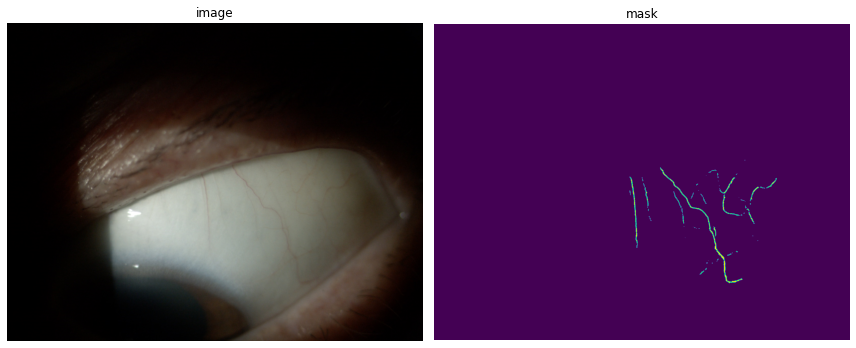

(1232, 1624)
[  0 255]


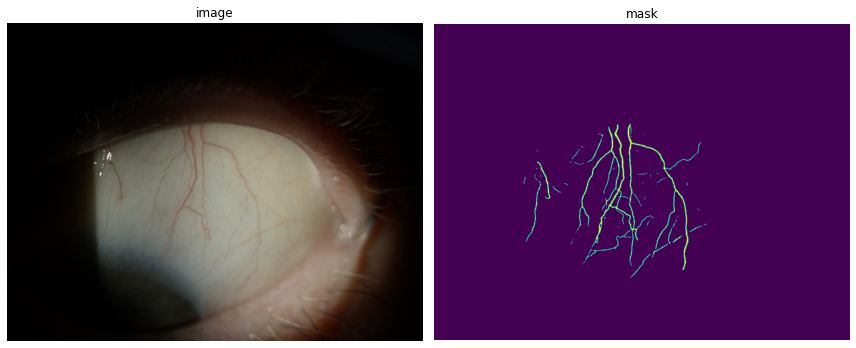

In [17]:
for img, msk in zip(imgs[0][:2], pred_masks[:2]):
    mask_g = rgb2gray(msk)
    mask_x = mask_g * 255
    print(mask_x.shape)
    print(np.unique(mask_x))
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 2, 1); plt.imshow(img, cmap='bone');
    plt.axis('OFF'); plt.title('image')
    plt.subplot(1, 2, 2); plt.imshow(mask_x); plt.axis('OFF'); plt.title('mask')
    #plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(mask_x, alpha=0.4);
    #plt.axis('OFF'); plt.title('overlay')
    plt.tight_layout()
    plt.show()

In [18]:
print(len(pred_masks))
print(len(pred_ids))

301
301


In [19]:
for mask, id in tqdm(zip(pred_masks, pred_ids)):
  #mask = mask.astype(dtype=np.uint8)
  mask = rgb2gray(mask)
  mask = mask * 255
  save_image_path = f"/content/gdrive/My Drive/oct_segmentation/submit/{id}.png"
  cv2.imwrite(save_image_path, mask)

301it [00:09, 31.75it/s]


In [20]:
import zipfile
  
PATH = '/content/gdrive/My Drive/oct_segmentation/submit/'

test_files = [f for f in os.listdir(PATH) if isfile(join(PATH, f))]

with zipfile.ZipFile('/content/gdrive/My Drive/oct_segmentation/submit.zip', 'w') as zipF:
  for file in test_files:
    zipF.write(PATH + file, file, compress_type=zipfile.ZIP_STORED)

In [ ]:
def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = np.array(image / 255, dtype=np.float32)
        return image


path = '/content/gdrive/My Drive/oct_segmentation/submit/784.png'
img = read_image(path)
print(img.shape)
print(np.unique(img))